# Проект "Car price prediction".

## Нужно построить модель, предсказывающую цену автомобиля и выигать соревнование. Данные для обучения отсутствуют. Нужно путем парсинга взять их с сайта авто.ру (или другого).

In [1]:
import os
import numpy as np
import pandas as pd

In [2]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#Этот блок нужен только на Kaggle
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

#Этот блок нужен только на локальной машине
print(os.listdir('./data'))
PATH_to_file = './data/'

['audi.csv', 'bmw.csv', 'bmw_new.csv', 'honda.csv', 'infiniti.csv', 'lexus.csv', 'mercedes.csv', 'mercedes_old.csv', 'mitsubishi.csv', 'nissan.csv', 'sample_submission.csv', 'skoda.csv', 'test.csv', 'toyota.csv', 'train.csv', 'train_new.csv', 'volkswagen.csv', 'volvo.csv']


In [3]:
import sys
import time
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_regression, mutual_info_regression, f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from pandas import Series

from sklearn.metrics import mean_absolute_error, mean_squared_error 
from math import sqrt

from sklearn.base import clone
import datetime
from datetime import datetime, timedelta
import math

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from pprint import pprint

In [5]:
#import ipython_exit
#import helper_v31102020 as utils

In [6]:
pd.set_option('display.max_columns', 50)
pd.set_option('max_colwidth', 200)

In [7]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [8]:
RANDOM_SEED = 42

In [9]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

## Этап I. Тестовый датасет
Исследуем тестовый датасет, чтобы понять, какие данные нам нужны в тренировочном датасете

In [10]:
#Этот блок нужен только на Kaggle
# DIR_TEST   = '../input/sf-dst-car-price-prediction/'
# test = pd.read_csv(DIR_TEST+'test.csv')
# sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')

In [11]:
#Этот блок нужен только на локальной машине
test = pd.read_csv(PATH_to_file + 'test.csv')
sample_submission = pd.read_csv(PATH_to_file + 'sample_submission.csv')

In [12]:
test.sample(3)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
25193,внедорожник 5 дв.,VOLKSWAGEN,https://auto.ru/cars/used/sale/volkswagen/tiguan/1100500066-57b4015a/,серебристый,"{""id"":""7344504"",""name"":""Trend&Fun"",""available_options"":[""heated-wash-system"",""airbag-passenger"",""roof-rails"",""lock"",""electro-mirrors"",""mirrors-heat"",""computer"",""seat-transformation"",""light-cleaner...","куплен у официального дилера Autoalea.своевременно обслуживался по гарантии. есть сервисная книжка.Оригинальный ПТС, один владелец. Куплен не в кредит.не участвовал в ДТП. Оба комплекта резины на ...",1.4 LTR,150 N12,"{""asr"":true,""tinted-glass"":true,""esp"":true,""multi-wheel"":true,""audiosystem-tv"":true,""heated-wash-system"":true,""ashtray-and-cigarette-lighter"":true,""airbag-passenger"":true,""front-centre-armrest"":tr...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/2164928/ab920ed2576f3d39c38b6fababbd4181/320x240,150000,2011,"{""code"":""TIGUAN"",""name"":""Tiguan"",""ru_name"":""Тигуан"",""morphology"":{},""nameplate"":{""code"":"""",""name"":"""",""semantic_url"":""""}}",TIGUAN,1.4 AMT (150 л.с.),5,1603220425,RUB,2013,1100500066,"{""id"":""9335284"",""displacement"":1390,""engine_type"":""GASOLINE"",""gear_type"":""FORWARD_CONTROL"",""transmission"":""ROBOT"",""power"":150,""power_kvt"":110,""human_name"":""1.4 AMT (150 л.с.)"",""acceleration"":9.6,""...",ALLROAD_5_DOORS ROBOT 1.4,роботизированная,EUROPEAN,1 владелец,7 лет и 5 месяцев,Оригинал,передний,Левый,Не требует ремонта,Растаможен
4977,хэтчбек 5 дв.,AUDI,https://auto.ru/cars/used/sale/audi/a3/1096495456-2d7b61b6/,белый,NaN,Все вопросы по телефону или смс,2.0 LTR,150 N12,NaN,бензин,https://avatars.mds.yandex.net/get-verba/787013/2a000001609d3d09d3cd3dc6ba6c0f901d73/wizardv3mr,173000,2004,"{""code"":""A3"",""name"":""A3"",""ru_name"":""А3"",""morphology"":{},""nameplate"":{""code"":"""",""name"":"""",""semantic_url"":""""}}",A3,2.0 AT (150 л.с.),5,1603131724,RUB,2005,1096495456,"{""id"":""20388979"",""displacement"":1984,""engine_type"":""GASOLINE"",""gear_type"":""FORWARD_CONTROL"",""transmission"":""AUTOMATIC"",""power"":150,""power_kvt"":110,""human_name"":""2.0 AT (150 л.с.)"",""acceleration"":9...",HATCHBACK_5_DOORS AUTOMATIC 2.0,автоматическая,EUROPEAN,3 или более,NaN,Дубликат,передний,Левый,Не требует ремонта,Растаможен
31356,внедорожник 5 дв.,VOLVO,https://auto.ru/cars/used/sale/volvo/xc90/1101351018-213145e9/,зелёный,NaN,"Продаю шикарный автомобиль, состояние хорошее по кузову живой,без дтп вся в родной краске технически без каких либо вложений обслуженный полностью ,обслуживается у дилера ,двигатель и акпп на 5. ...",2.5 LTR,210 N12,"{""cruise-control"":true,""asr"":true,""tinted-glass"":true,""esp"":true,""adaptive-light"":true,""usb"":true,""multi-wheel"":true,""audiopreparation"":true,""xenon"":true,""airbag-passenger"":true,""front-centre-armr...",бензин,https://autoru.naydex.net/cSRr96A18/708ec0RhY5eU/ltifIE2VpY8OEtoEUgcl8A4pxbiUSJmmy1wtWL4hITIoUqXijAE00U2TQLY-ILcoqb-SG9M7dR-48ywRYHLj9fMZS8XcwPTqHyPe8eJmVETLfdDN4M38Y98bLtr9d9LRijDGsUowRXE5krQS-JY...,247000,2006,"{""code"":""XC90"",""name"":""XC90"",""ru_name"":""XC90"",""morphology"":{},""nameplate"":{""code"":"""",""name"":"""",""semantic_url"":""""}}",XC90,2.5 AT (210 л.с.) 4WD,5,1603585007,RUB,2006,1101351018,"{""id"":""2310050"",""displacement"":2521,""engine_type"":""GASOLINE"",""gear_type"":""ALL_WHEEL_DRIVE"",""transmission"":""AUTOMATIC"",""power"":210,""power_kvt"":154,""human_name"":""2.5 AT (210 л.с.) 4WD"",""acceleration...",ALLROAD_5_DOORS AUTOMATIC 2.5,автоматическая,EUROPEAN,3 или более,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен


In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

У нас 32 признака, 6 из них - числовые.  

Посмотрим на типичные значения в разных колонках тестового датасета, исключив признаки, которые не будем использовать:

In [14]:
for col in test.columns:
    if col not in ['complectation_dict', 'equipment_dict', 'Владение', 'car_url', 'image']:
        print(f'Column: {col}','\n', test[col].value_counts()[:10], '\n')

Column: bodyType 
 седан                   13147
внедорожник 5 дв.       12228
лифтбек                  2232
хэтчбек 5 дв.            2124
универсал 5 дв.          1276
минивэн                   995
купе                      824
компактвэн                489
хэтчбек 3 дв.             485
пикап двойная кабина      280
Name: bodyType, dtype: int64 

Column: brand 
 BMW           4473
VOLKSWAGEN    4404
NISSAN        4393
MERCEDES      4180
TOYOTA        3913
AUDI          3421
MITSUBISHI    2843
SKODA         2741
VOLVO         1463
HONDA         1150
Name: brand, dtype: int64 

Column: color 
 чёрный         11010
белый           6133
серебристый     4113
серый           3984
синий           3289
красный         1531
коричневый      1501
зелёный          952
бежевый          639
голубой          457
Name: color, dtype: int64 

Column: description 
 Выгода до 82 000 руб. при обмене на Ваш автомобиль! \nВыгода при покупке в кредит до 100 000 руб.! \nРОЛЬФ ЯСЕНЕВО с пробегом. \n-Мы принима

Column: ПТС 
 Оригинал    30098
Дубликат     4587
Name: ПТС, dtype: int64 

Column: Привод 
 передний    15565
полный      15020
задний       4101
Name: Привод, dtype: int64 

Column: Руль 
 Левый     33287
Правый     1399
Name: Руль, dtype: int64 

Column: Состояние 
 Не требует ремонта    34686
Name: Состояние, dtype: int64 

Column: Таможня 
 Растаможен    34686
Name: Таможня, dtype: int64 



## Этап II. Парсинг.

Парсинг проводился на локальной машине. В результате получлся тренировочный датасет train.csv с 26957 записей. Мы можем использовать его для обучения.
Код для парсинга приводится в файле **grigoriyk-car-price-prediction_parsing**

## Этап III. Предобработка данных.

### Часть 1. Приведение train и test к соответствию по признакам.

In [15]:
# Этот блок нужен только на Kaggle
# DIR_TRAIN   = '../input/car-price-train/'
# train = pd.read_csv(DIR_TRAIN+'my_csv_export.csv')

In [16]:
# Этот блок нужен на локальной машине
train = pd.read_csv(PATH_to_file + 'train.csv')

In [17]:
train.shape

(26957, 16)

In [18]:
train.sample(3)

,page,bodyType,brand,color,fuelType,modelDate,model_name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,price,temp1,engineDisplacement,enginePower,mileage
10568,91,хэтчбек 5 дв.,NISSAN,серебристый,бензин,1999.0,Nissan Primera II (P11) Рестайлинг,5.0,2000,HATCHBACK_5_DOORS MECHANICAL 2.0,механическая,150000,2.0 MT,2.0 LTR,140 N12,229 640 км
9583,64,хэтчбек 5 дв.,NISSAN,бежевый,бензин,2005.0,Nissan Note I,5.0,2007,HATCHBACK_5_DOORS MECHANICAL 1.4,механическая,305000,1.4 MT,1.4 LTR,88 N12,210 000 км
15201,26,хэтчбек 5 дв.,TOYOTA,серебристый,бензин,2003.0,"Toyota Corolla IX (E120, E130) Рестайлинг",5.0,2004,HATCHBACK_5_DOORS MECHANICAL 1.6,механическая,310000,1.6 MT,1.6 LTR,110 N12,163 002 км


Удалим столбец page, который использовался при парсинге для анализа распределения объявлений по страницам

In [19]:
train.drop(['page'], axis=1, inplace=True)

In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26957 entries, 0 to 26956
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              26957 non-null  object 
 1   brand                 26957 non-null  object 
 2   color                 26957 non-null  object 
 3   fuelType              26957 non-null  object 
 4   modelDate             26957 non-null  float64
 5   model_name            26957 non-null  object 
 6   numberOfDoors         26957 non-null  float64
 7   productionDate        26957 non-null  int64  
 8   vehicleConfiguration  26957 non-null  object 
 9   vehicleTransmission   26957 non-null  object 
 10  price                 26957 non-null  int64  
 11  temp1                 26957 non-null  object 
 12  engineDisplacement    26957 non-null  object 
 13  enginePower           26957 non-null  object 
 14  mileage               26957 non-null  object 
dtypes: float64(2), int6

Остается 13 признаков и целевая переменная 'price'  

### Теперь приводим столбцы в train в соответствие со столбцами в test

In [21]:
train['mileage'] = train['mileage'].apply(lambda x: int(x.replace(' ', '').replace('км', '')))

Меняем тип числовых переменных на int64 в train

In [22]:
num_fields = ['modelDate', 'productionDate', 'numberOfDoors', 'mileage']
for col in num_fields:
    train[col] = train[col].astype('int64')

In [23]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26957 entries, 0 to 26956
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              26957 non-null  object
 1   brand                 26957 non-null  object
 2   color                 26957 non-null  object
 3   fuelType              26957 non-null  object
 4   modelDate             26957 non-null  int64 
 5   model_name            26957 non-null  object
 6   numberOfDoors         26957 non-null  int64 
 7   productionDate        26957 non-null  int64 
 8   vehicleConfiguration  26957 non-null  object
 9   vehicleTransmission   26957 non-null  object
 10  price                 26957 non-null  int64 
 11  temp1                 26957 non-null  object
 12  engineDisplacement    26957 non-null  object
 13  enginePower           26957 non-null  object
 14  mileage               26957 non-null  int64 
dtypes: int64(5), object(10)
memory usage

Сравниваем train и test

In [24]:
test_columns_to_drop = ['car_url', 'complectation_dict', 'description', 'image', 'model_info', 'super_gen',
                        'Владельцы', 'Владение', 'ПТС', 'Привод', 'Руль', 'Состояние', 'Таможня', 'equipment_dict',
                        'parsing_unixtime', 'priceCurrency', 'sell_id']
display(train.sample(3))
display(test.drop(test_columns_to_drop, axis=1).sample(3))

,bodyType,brand,color,fuelType,modelDate,model_name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,price,temp1,engineDisplacement,enginePower,mileage
20815,внедорожник 5 дв.,MITSUBISHI,серебристый,бензин,2006,Mitsubishi Pajero IV,5,2007,ALLROAD_5_DOORS AUTOMATIC 3.8,автоматическая,980000,3.8 AT,3.8 LTR,250 N12,150000
10953,купе,MERCEDES,зелёный,бензин,2016,"Mercedes-Benz E-Класс V (W213, S213, C238) 200",2,2018,COUPE AUTOMATIC 2.0,автоматическая,3269000,2.0 AT,2.0 LTR,184 N12,11939
25149,минивэн,HONDA,серый,бензин,2012,Honda Stepwgn IV Рестайлинг,5,2014,MINIVAN VARIATOR 2.0,вариатор,1150000,2.0 CVT,2.0 LTR,150 N12,124000


,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,vendor
12628,внедорожник 5 дв.,NISSAN,чёрный,2.5 LTR,169 N12,бензин,131230,2007,X_TRAIL,2.5 CVT (169 л.с.) 4WD,5,2007,ALLROAD_5_DOORS VARIATOR 2.5,вариатор,JAPANESE
705,внедорожник 5 дв.,SKODA,белый,1.8 LTR,152 N12,бензин,63000,2013,YETI,1.8 AMT (152 л.с.) 4WD,5,2016,ALLROAD_5_DOORS ROBOT 1.8,роботизированная,EUROPEAN
12364,внедорожник 5 дв.,NISSAN,белый,1.2 LTR,115 N12,бензин,23350,2013,QASHQAI,1.2 CVT (115 л.с.),5,2018,ALLROAD_5_DOORS VARIATOR 1.2,вариатор,JAPANESE


Видим, что есть некоторое соответствие между признаками **model_name** на test и train

Глядя на признак **model_name** видим, что на test он короче. Попробуем выделить короткое название модели на train

In [25]:
display(test[test.brand=='BMW'].model_name.value_counts()[:10], train[train.brand=='BMW'].model_name.value_counts()[:10]) 

5ER    1026
3ER     752
X5      675
7ER     343
X6      317
X3      283
1ER     218
X1      215
6ER     122
X4       96
Name: model_name, dtype: int64

BMW X6  II (F16) 30d                                81
BMW 5 серии  VII (G30/G31) 520d xDrive              57
BMW X5  II (E70) Рестайлинг 35i                     49
BMW X6  I (E71) 35i                                 45
BMW X5  III (F15) 30d                               45
BMW 3 серии  VI (F3x) 320i                          44
BMW X5  II (E70) 3.0si                              42
BMW 5 серии  VII (G30/G31) 530d xDrive              42
BMW 5 серии  VI (F10/F11/F07) Рестайлинг 520d       37
BMW 1 серии  I (E81/E82/E87/E88) Рестайлинг 116i    37
Name: model_name, dtype: int64

In [26]:
# Вырезаем brand в train и меняем прописные буквы на заглавные 
train['model_name'] = train['model_name'].apply(lambda x: (x.split(' ')[1]).upper())

In [27]:
# Берем первую часть двойных названий
train['model_name'] = train['model_name'].apply(lambda x: x.split('-')[0])
test['model_name'] = test['model_name'].apply(lambda x: x.split('_')[0])

In [28]:
# Если модель начинается с цифры, берем только эту цифру (актуально для BMW)
train['model_name'] = train['model_name'].apply(lambda x: x[0] if str.isdigit(x[0]) else x)
test['model_name'] = test['model_name'].apply(lambda x: x[0] if str.isdigit(x[0]) else x)

In [29]:
# Убираем другие "нестандартные" символы
train['model_name'] = train['model_name'].apply(lambda x: x.split('+')[0])
test['model_name'] = test['model_name'].apply(lambda x: x.split('+')[0])

Нам удается добиться хорошего соответствия моделей:

In [30]:
display(np.sort(test[test.brand == 'AUDI'].model_name.unique()),
        np.sort(train[train.brand == 'AUDI'].model_name.unique()))

array(['1', '2', '8', '9', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8',
       'ALLROAD', 'COUPE', 'E', 'Q3', 'Q5', 'Q7', 'Q8', 'R8', 'RS3',
       'RS4', 'RS5', 'RS6', 'RS7', 'RSQ3', 'S3', 'S4', 'S5', 'S6', 'S7',
       'S8', 'SQ5', 'TT', 'TTS', 'V8'], dtype=object)

array(['1', '2', '8', '9', 'A1', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8',
       'COUPE', 'Q3', 'Q5', 'Q7', 'Q8', 'R8', 'RS', 'S2', 'S3', 'S4',
       'S5', 'S6', 'S7', 'S8', 'SQ5', 'SQ7', 'SQ8', 'TT', 'TTS'],
      dtype=object)

По аналогии с test добавим в train признак 'vendor'

In [31]:
euro = ['BMW', 'VOLKSWAGEN', 'MERCEDES', 'AUDI', 'SKODA', 'VOLVO']
train['vendor'] = train['brand'].apply(lambda x: 'EUROPEAN' if x in euro else 'JAPANESE')

Выбираем признаки для дальнейшей работы  

In [32]:
columns = ['bodyType', 'brand', 'color', 'fuelType', 'modelDate', 'model_name', 'numberOfDoors',
           'productionDate', 'vehicleConfiguration', 'vehicleTransmission', 'engineDisplacement',
           'enginePower', 'mileage', 'vendor']
cars_train = train[columns].copy()
cars_test = test[columns].copy()

 Помечаем тренировочный датасет признаком 'sample'= 1 и объединчем оба датасета в общий, cars:

In [33]:
cars_train.loc[:, 'sample'] = 1
cars_test.loc[:, 'sample'] = 0
cars = cars_train.append(cars_test, ignore_index=True, sort=False)

Выделим целевую переменную:

In [34]:
# Целевая переменная
y = train['price']

### Часть 2. Обработка признаков.

In [35]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61643 entries, 0 to 61642
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              61643 non-null  object
 1   brand                 61643 non-null  object
 2   color                 61643 non-null  object
 3   fuelType              61643 non-null  object
 4   modelDate             61643 non-null  int64 
 5   model_name            61643 non-null  object
 6   numberOfDoors         61643 non-null  int64 
 7   productionDate        61643 non-null  int64 
 8   vehicleConfiguration  61643 non-null  object
 9   vehicleTransmission   61643 non-null  object
 10  engineDisplacement    61643 non-null  object
 11  enginePower           61643 non-null  object
 12  mileage               61643 non-null  int64 
 13  vendor                61643 non-null  object
 14  sample                61643 non-null  int64 
dtypes: int64(5), object(10)
memory usage

In [36]:
cars.sample(5)

,bodyType,brand,color,fuelType,modelDate,model_name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,mileage,vendor,sample
12017,внедорожник 5 дв.,MERCEDES,чёрный,бензин,1994,G,5,2004,ALLROAD_5_DOORS AUTOMATIC 5.4,автоматическая,5.4 LTR,476 N12,109695,EUROPEAN,1
27385,лифтбек,SKODA,бежевый,бензин,2008,OCTAVIA,5,2013,LIFTBACK AUTOMATIC 1.6,автоматическая,1.6 LTR,102 N12,167000,EUROPEAN,0
10159,внедорожник 5 дв.,NISSAN,чёрный,бензин,2013,X,5,2018,ALLROAD_5_DOORS VARIATOR 2.5,вариатор,2.5 LTR,171 N12,57000,JAPANESE,1
2154,седан,BMW,белый,бензин,2009,5,4,2013,SEDAN AUTOMATIC 2.0,автоматическая,2.0 LTR,184 N12,101000,EUROPEAN,1
45309,внедорожник 5 дв.,MERCEDES,голубой,бензин,2008,M,5,2009,ALLROAD_5_DOORS AUTOMATIC 5.5,автоматическая,5.5 LTR,388 N12,130500,EUROPEAN,0


Имеем 14 признаков, не считая "sample", из них 3 - числовые (признак numberOfDoors по сути категориальный).  
При этом два категориальных признака: "enginePower" и "engineDisplacement" обозначают объем и мощьность двигателя и их нужно преобразовать в числовые. 

In [37]:
# Количество уникальных значений у этих признаков
print(cars['enginePower'].nunique(), cars['engineDisplacement'].nunique())

321 55


In [38]:
cars.engineDisplacement.unique()

array(['3.0 LTR', '4.4 LTR', '1.5 LTR', '2.0 LTR', '1.6 LTR', '2.5 LTR',
       '4.8 LTR', '3.4 LTR', '2.8 LTR', '2.2 LTR', '1.9 LTR', '0.7 LTR',
       '6.0 LTR', '6.6 LTR', '5.0 LTR', '4.0 LTR', '4.9 LTR', '3.8 LTR',
       '5.4 LTR', ' LTR', '3.3 LTR', '3.9 LTR', '3.5 LTR', '2.9 LTR',
       '1.8 LTR', '2.3 LTR', '3.2 LTR', '4.6 LTR', '3.6 LTR', '2.4 LTR',
       '1.2 LTR', '1.4 LTR', '4.2 LTR', '2.1 LTR', '4.1 LTR', '1.0 LTR',
       '1.7 LTR', '1.3 LTR', '5.6 LTR', '2.6 LTR', '2.7 LTR', '4.5 LTR',
       '5.5 LTR', '4.7 LTR', '6.2 LTR', '3.7 LTR', '5.8 LTR', '4.3 LTR',
       '5.3 LTR', '5.7 LTR', '3.1 LTR', '6.3 LTR', '5.2 LTR', '5.9 LTR',
       '1.1 LTR'], dtype=object)

In [39]:
cars.engineDisplacement.value_counts()[:1]

2.0 LTR    13709
Name: engineDisplacement, dtype: int64

In [40]:
# Неполные значения в "engineDisplacement" заменим МОДОЙ (2.0 LTR):
cars['engineDisplacement'] = cars['engineDisplacement'].apply(lambda x: '2.0 LTR' if x == ' LTR' else x)

In [41]:
# Преобразуем в числовой:
cars['engineDisplacement'] = cars['engineDisplacement'].apply \
                             (lambda x: int(x.split(' ')[0].replace('.', '')))

In [42]:
cars.enginePower.unique()[:50]

array(['249 N12', '306 N12', '555 N12', '231 N12', '625 N12', '150 N12',
       '184 N12', '320 N12', '136 N12', '313 N12', '140 N12', '177 N12',
       '450 N12', '407 N12', '400 N12', '286 N12', '218 N12', '258 N12',
       '190 N12', '265 N12', '245 N12', '355 N12', '510 N12', '115 N12',
       '530 N12', '170 N12', '575 N12', '600 N12', '272 N12', '360 N12',
       '90 N12', '340 N12', '326 N12', '122 N12', '193 N12', '235 N12',
       '381 N12', '163 N12', '192 N12', '367 N12', '156 N12', '204 N12',
       '431 N12', '560 N12', '118 N12', '252 N12', '445 N12', '264 N12',
       '609 N12', '387 N12'], dtype=object)

In [43]:
cars['enginePower'] = cars['enginePower'].apply(lambda x: int(x.split(' ')[0]))

In [44]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61643 entries, 0 to 61642
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              61643 non-null  object
 1   brand                 61643 non-null  object
 2   color                 61643 non-null  object
 3   fuelType              61643 non-null  object
 4   modelDate             61643 non-null  int64 
 5   model_name            61643 non-null  object
 6   numberOfDoors         61643 non-null  int64 
 7   productionDate        61643 non-null  int64 
 8   vehicleConfiguration  61643 non-null  object
 9   vehicleTransmission   61643 non-null  object
 10  engineDisplacement    61643 non-null  int64 
 11  enginePower           61643 non-null  int64 
 12  mileage               61643 non-null  int64 
 13  vendor                61643 non-null  object
 14  sample                61643 non-null  int64 
dtypes: int64(7), object(8)
memory usage:

In [45]:
# Списки числовых и категориальных признаков в cars
num_f = ['modelDate', 'productionDate', 'mileage', 'enginePower', 'engineDisplacement']
cat_f = ['bodyType', 'brand', 'color', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleConfiguration',
         'vehicleTransmission', 'vendor']

### Числовые признаки

In [46]:
def analyse_numeric(df, column, bns=30):
    '''Визуализирует распределения числовых переменных.
       Принимает параметром строковое название столбца
       Печатает различные статистические показатели и строит гистограмму'''
    count = df[column].count()
    mean = df[column].mean()
    std = df[column].std()
    median = df[column].median()
    perc25 = df[column].quantile(0.25)
    perc75 = df[column].quantile(0.75)
    IQR = perc75 - perc25
    range_min = df[column].min()
    range_max = df[column].max()
    margin = (range_max - range_min)/10
    range_start = range_min - margin
    range_stop = range_max + margin
    range_ = (range_start, range_stop)
    outliers = df[column].loc[(df[column] < perc25 - 1.5*IQR) | (df[column] > perc75 + 1.5*IQR)]

    print('Количество: {}, Среднее: {:.3f}, Стандартное отклонение: {:.3f}.'.format(count, mean, std))
    print('Минимум: {}, 25-й перцентиль: {}, Медиана: {}, 75-й перцентиль: {}, Максимум: {}, IQR: {}.'
          .format(range_min, perc25, median, perc75, range_max, IQR))
    print('Количество пропусков в столбце: ', pd.isnull(df[column]).sum())
    print('Границы выбросов: [{f}, {l}].'.format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR)
          , 'Количество выбросов: ', len(outliers))

    fig = plt.figure()
    fig.suptitle(column, fontsize=15)    
    
    df[column].loc[df[column].between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)] \
                    .hist(bins = bns, range = range_, label = 'В границах выбросов')
    outliers.hist(bins = bns, range = range_, label = 'Выбросы')
    plt.legend()

Количество: 61643, Среднее: 2007.470, Стандартное отклонение: 7.504.
Минимум: 1904, 25-й перцентиль: 2004.0, Медиана: 2009.0, 75-й перцентиль: 2013.0, Максимум: 2020, IQR: 9.0.
Количество пропусков в столбце:  0
Границы выбросов: [1990.5, 2026.5]. Количество выбросов:  2098


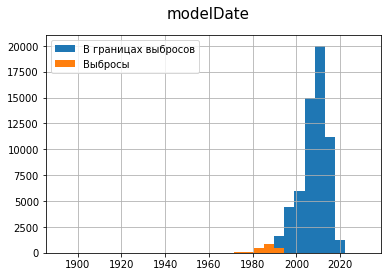

In [47]:
analyse_numeric(cars, 'modelDate')

Количество: 61643, Среднее: 2009.652, Стандартное отклонение: 7.140.
Минимум: 1904, 25-й перцентиль: 2006.0, Медиана: 2011.0, 75-й перцентиль: 2015.0, Максимум: 2020, IQR: 9.0.
Количество пропусков в столбце:  0
Границы выбросов: [1992.5, 2028.5]. Количество выбросов:  1780


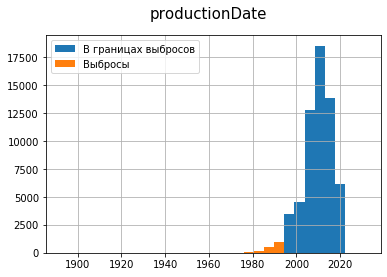

In [48]:
analyse_numeric(cars, 'productionDate')

Количество: 61643, Среднее: 157808.554, Стандартное отклонение: 100735.827.
Минимум: 1, 25-й перцентиль: 86000.0, Медиана: 145000.0, 75-й перцентиль: 210000.0, Максимум: 1000000, IQR: 124000.0.
Количество пропусков в столбце:  0
Границы выбросов: [-100000.0, 396000.0]. Количество выбросов:  1476


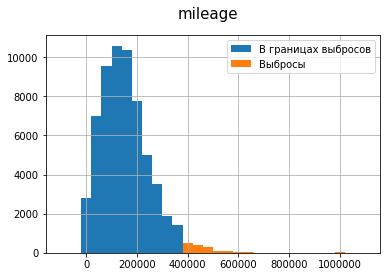

In [49]:
analyse_numeric(cars, 'mileage')

Количество: 61643, Среднее: 189.057, Стандартное отклонение: 89.100.
Минимум: 30, 25-й перцентиль: 129.0, Медиана: 170.0, 75-й перцентиль: 235.0, Максимум: 639, IQR: 106.0.
Количество пропусков в столбце:  0
Границы выбросов: [-30.0, 394.0]. Количество выбросов:  2192


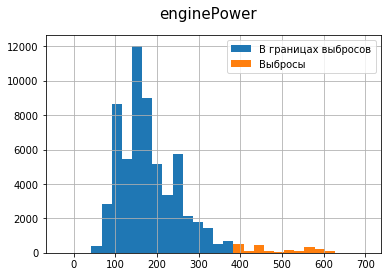

In [50]:
analyse_numeric(cars, 'enginePower')

Количество: 61643, Среднее: 24.032, Стандартное отклонение: 9.577.
Минимум: 7, 25-й перцентиль: 18.0, Медиана: 20.0, 75-й перцентиль: 30.0, Максимум: 66, IQR: 12.0.
Количество пропусков в столбце:  0
Границы выбросов: [0.0, 48.0]. Количество выбросов:  1720


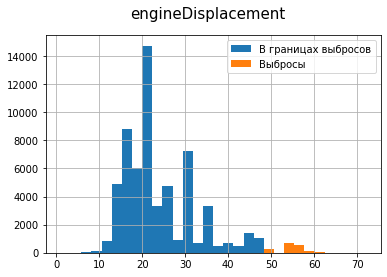

In [51]:
analyse_numeric(cars, 'engineDisplacement')

Распределения у признаков в каком-то приближении близки к нормальным, справа или слева имеются длинные хвосты.  
Очень много технических выбросов, но введение даже логических границ ухудшало оценку и на Kaggle не использовалось.

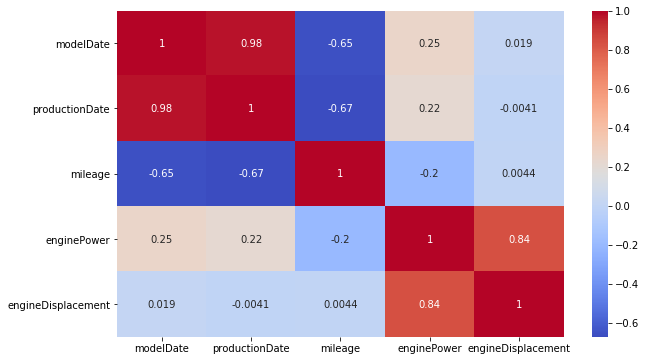

In [52]:
# Посмотрим корреляцию числовых признаков
correlation = cars[num_f].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm')

Выводы по рассмотрению корреляции числовых признаков:  
  +0.98 между годом выпуска и годом модели, видимо, имеет смысл один из этих  признаков убрать или заменить на их разность  
  +0.84 между мощностью и объемом двигателя  
  -0.67 между пробегом и годом производства, здесь тоже можно создать новый признак типа пробег/возраст

### Категориальные признаки

In [53]:
for col in cat_f:
    print(col, cars[col].nunique(), '\n', cars[col].value_counts()[:3], '\n')

bodyType 25 
 седан                22596
внедорожник 5 дв.    22527
лифтбек               3974
Name: bodyType, dtype: int64 

brand 12 
 BMW           8100
VOLKSWAGEN    8057
MERCEDES      7850
Name: brand, dtype: int64 

color 16 
 чёрный         19417
белый          11367
серебристый     7133
Name: color, dtype: int64 

fuelType 5 
 бензин    50357
дизель    10777
гибрид      391
Name: fuelType, dtype: int64 

model_name 451 
 OCTAVIA    2531
5          1777
LAND       1686
Name: model_name, dtype: int64 

numberOfDoors 5 
 5    34011
4    24356
2     2165
Name: numberOfDoors, dtype: int64 

vehicleConfiguration 676 
 ALLROAD_5_DOORS AUTOMATIC 3.0    4450
SEDAN AUTOMATIC 2.0              2981
ALLROAD_5_DOORS AUTOMATIC 2.0    2590
Name: vehicleConfiguration, dtype: int64 

vehicleTransmission 4 
 автоматическая      34923
механическая        12294
роботизированная     7243
Name: vehicleTransmission, dtype: int64 

vendor 2 
 EUROPEAN    37267
JAPANESE    24376
Name: vendor, dtype: int

Заметим, что признаки 'model_name' и  'vehicleConfiguration' имеют очень большой спектр значений(451 и 676)   
Остальные 7 категориальных признаков имеют небольшие спектры значений.

### Часть 3. Feature Engineering (генерация новых признаков)

Создадим бинарный категориальный признаки: "allroad" - наличие полного привода и "luxury" - принадлежность к "элитным" маркам автомобилей: 'BMW','MERCEDES','LEXUS','INFINITI'.

In [54]:
cars['allroad'] = cars['vehicleConfiguration'].apply(lambda x: 1 if x.split('_')[0] == 'ALLROAD' else 0)
cat_f.append('allroad')

In [55]:
cars['luxury'] = cars['brand'].apply(lambda x: 1 if x in ['BMW','MERCEDES','LEXUS','INFINITI'] else 0)
cat_f.append('luxury')

Из числовых, как и планировали выше, сделаем:  
    'model_age' - новизна модели на момент производства  
    'km_per_year' - интенсивность эксплуатации(пробег/год)

In [56]:
cars['model_age'] = cars['productionDate'] - cars['modelDate']
cars['model_age'] = cars['model_age'].apply(lambda x: 0 if x < 0 else x)
cars['km_per_year'] = (cars['mileage']/(2021 - cars['productionDate'])).astype('int64')
num_f.append('model_age')
num_f.append('km_per_year')

Построим их гистограммы

Количество: 61643, Среднее: 2.182, Стандартное отклонение: 1.665.
Минимум: 0, 25-й перцентиль: 1.0, Медиана: 2.0, 75-й перцентиль: 3.0, Максимум: 46, IQR: 2.0.
Количество пропусков в столбце:  0
Границы выбросов: [-2.0, 6.0]. Количество выбросов:  954


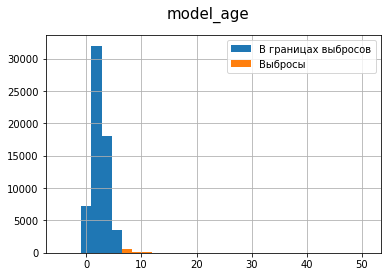

In [57]:
analyse_numeric(cars, 'model_age')

Количество: 61643, Среднее: 14822.778, Стандартное отклонение: 7294.161.
Минимум: 0, 25-й перцентиль: 10375.0, Медиана: 13888.0, 75-й перцентиль: 18076.5, Максимум: 110577, IQR: 7701.5.
Количество пропусков в столбце:  0
Границы выбросов: [-1177.25, 29628.75]. Количество выбросов:  2107


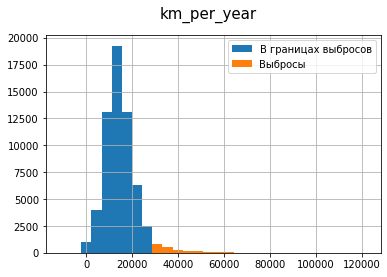

In [58]:
analyse_numeric(cars, 'km_per_year')

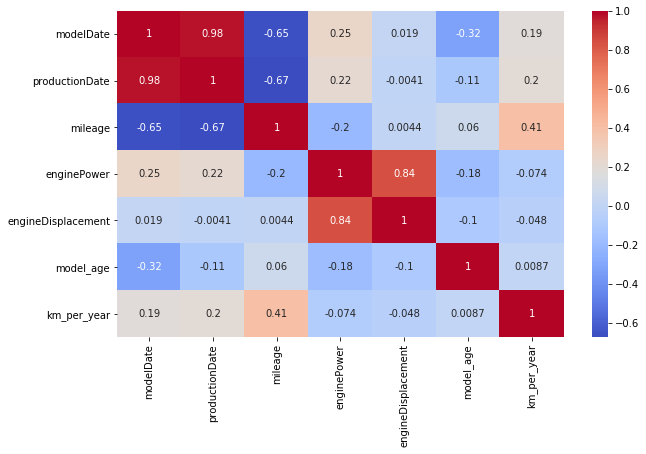

In [59]:
# Снова построим heatmap. Видим, что новые признаки не имеют сильных корреляций
correlation = cars[num_f].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm')

Посмотрим на значимость числовых переменных

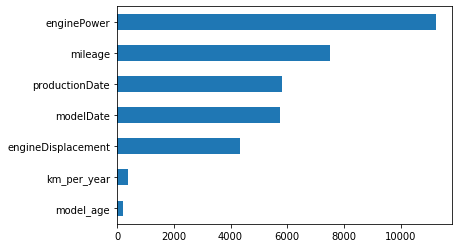

In [60]:
# по f_regression:
imp_num = Series(f_regression(cars[cars['sample'] == 1][num_f], y)[0], index = num_f)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

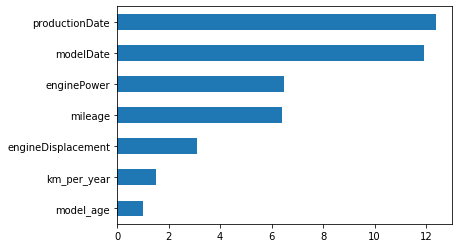

In [61]:
# по f_classif:
imp_num = Series(f_classif(cars[cars['sample'] == 1][num_f], y)[0], index = num_f)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Создадим полиномиальные новые признаки на основе двух числовых 'productionDate' и 'enginePower' и нормируем их

In [62]:
pf = PolynomialFeatures(3)
poly_features = pf.fit_transform(cars[[ 'productionDate', 'enginePower']])
poly = pd.DataFrame(poly_features).drop([0,1,2,3,4,6,8], axis = 1)
poly.columns = ['date_power5', 'date_power7', 'date_power9']

for col in list(poly.columns):
    col_max = poly[col].max()    
    poly[col] = poly[col].apply(lambda x: int(round(100000*x/col_max, 0)))
    
cars = pd.concat([cars, poly], axis=1)
num_f = num_f + list(poly.columns)

In [63]:
cars.sample(3)

,bodyType,brand,color,fuelType,modelDate,model_name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,mileage,vendor,sample,allroad,luxury,model_age,km_per_year,date_power5,date_power7,date_power9
34710,кабриолет,BMW,фиолетовый,бензин,2007,6,2,2007,CABRIO AUTOMATIC 4.8,автоматическая,48,367,80000,EUROPEAN,0,0,1,0,5714,32986,56697,18945
24810,внедорожник 5 дв.,VOLVO,чёрный,бензин,2006,XC90,5,2008,ALLROAD_5_DOORS AUTOMATIC 2.5,автоматическая,25,210,168500,EUROPEAN,1,1,0,2,12961,10800,32475,3549
46318,седан,TOYOTA,серебристый,бензин,2003,COROLLA,4,2006,SEDAN MECHANICAL 1.4,механическая,14,97,100962,JAPANESE,0,0,0,3,6730,2304,14970,350


Проверим значимость числовых признаков, включая полиномиальные

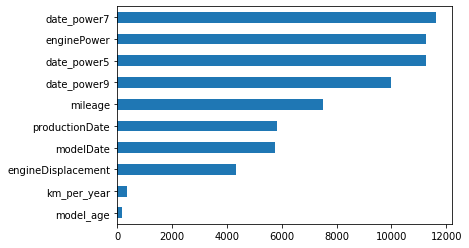

In [64]:
imp_num = Series(f_regression(cars[cars['sample'] == 1][num_f], y)[0], index = num_f)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

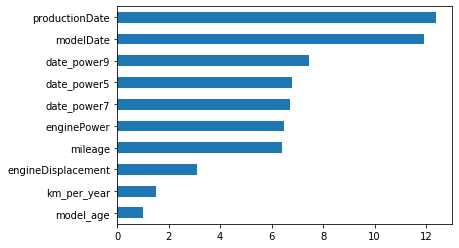

In [65]:
imp_num = Series(f_classif(cars[cars['sample'] == 1][num_f], y)[0], index = num_f)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Посмотрим на корреляционную матрицу

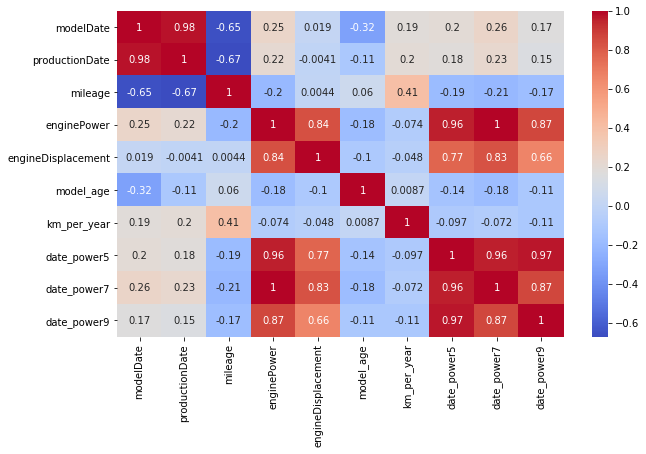

In [66]:
correlation = cars[num_f].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm')

Полиномиальные признаки показывают высокую значимость для целевой переменной, но  
они очень сильно скоррелированны со своими предшественниками.
Попробуем в дальнейшем запускать модели с ними и без них

In [67]:
f_candidates_to_drop = ['modelDate', 'engineDisplacement', 'date_power5', 'date_power7', 'date_power9']
num_f_temp = [item for item in num_f if item not in f_candidates_to_drop]
num_f_temp

['productionDate', 'mileage', 'enginePower', 'model_age', 'km_per_year']

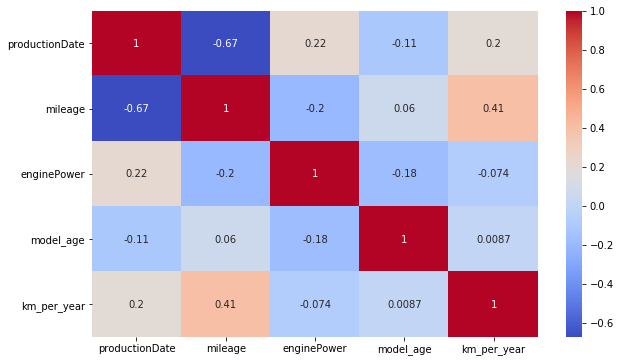

In [68]:
correlation = cars.drop(f_candidates_to_drop, axis = 1)[num_f_temp].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm')

In [69]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61643 entries, 0 to 61642
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              61643 non-null  object
 1   brand                 61643 non-null  object
 2   color                 61643 non-null  object
 3   fuelType              61643 non-null  object
 4   modelDate             61643 non-null  int64 
 5   model_name            61643 non-null  object
 6   numberOfDoors         61643 non-null  int64 
 7   productionDate        61643 non-null  int64 
 8   vehicleConfiguration  61643 non-null  object
 9   vehicleTransmission   61643 non-null  object
 10  engineDisplacement    61643 non-null  int64 
 11  enginePower           61643 non-null  int64 
 12  mileage               61643 non-null  int64 
 13  vendor                61643 non-null  object
 14  sample                61643 non-null  int64 
 15  allroad               61643 non-null

### Часть 4. "Закодируем" категориальные признаки (Label Encoding)

In [70]:
# Кодируем категориальные признаки
for col in cat_f:
    cars[col] = cars[col].astype('category').cat.codes

In [71]:
X_train_test = cars.copy()
X_train_test.head(3)

,bodyType,brand,color,fuelType,modelDate,model_name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,mileage,vendor,sample,allroad,luxury,model_age,km_per_year,date_power5,date_power7,date_power9
0,1,1,15,3,2014,436,4,2018,42,0,30,249,32000,0,1,1,1,4,10666,15184,38890,5917
1,1,1,12,0,2010,435,4,2010,42,0,30,306,176000,0,1,1,1,0,16000,22932,47414,10982
2,1,1,15,0,2009,435,4,2012,54,0,44,555,89000,0,1,1,1,3,9888,75437,86168,65520


### Выводы по Этапу III. Предобработка данных:
В процессе предобработки данных добавлены:  
  - 2 новых бинарных категориальных признака **"allroad"** и **"luxury"** 
  - 5 новых числовых признаков: **"model_age", "km_per_year", "date_power5", "date_power7", "date_power9"**, 3 из которых - полиномиальные  
  - 2 новых числовых признака, переделанных из категориальных: **"enginePower" и "engineDisplacement"**
  
Выбросы не удалялись
  
Датасет содержит 10 числовых и 11 категориальных признаков  

Пока сохранены все признаки, включая сильно скоррелированные и определены кандидаты на удаление:
**"modelDate", "engineDisplacement", "date_power5", "date_power7", "date_power9"**

## Этап IV. Построение моделей.

In [72]:
# Разделяем обратно train и test
train = X_train_test.query('sample == 1').drop(['sample'], axis=1)
test = X_train_test.query('sample == 0').drop(['sample'], axis=1)

In [73]:
# Делим train для обучения и проверки моделей
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, shuffle=True, random_state=RANDOM_SEED)

In [74]:
#Определим функцию для вывода значений метрик
def print_metrics(tst, prd):
    print('MAPE: ', 100*mape(tst, prd), '%')
    print('MAE:', mean_absolute_error(tst, prd))
    print('MSE:', mean_squared_error(tst, prd))
    print('RMSE:', sqrt(mean_squared_error(tst, prd)))

### Model 0. "Наивная".
Построим модель по одному признаку enginePower.

In [75]:
tmp_train = X_train.copy()
tmp_train['price'] = y_train

In [76]:
# Находим median по экземплярам enginePower в трейне и размечаем тест
predict = X_test['enginePower'].map(tmp_train.groupby('enginePower')['price'].median())

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict.values))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 58.18%


### Model 1. Random Forest.
С этой моделью будем сравнивать другие.

In [77]:
rf = RandomForestRegressor(random_state=RANDOM_SEED)

rf.fit(X_train, y_train)
predict = rf.predict(X_test)
print_metrics(y_test, predict)

MAPE:  16.344532352380742 %
MAE: 171641.39000614226
MSE: 193990915411.94363
RMSE: 440443.99804282


Submission

In [78]:
sample_submission.head(3)

,sell_id,price
0,1100575026,0
1,1100549428,0
2,1100658222,0


In [79]:
test.head()

,bodyType,brand,color,fuelType,modelDate,model_name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,mileage,vendor,allroad,luxury,model_age,km_per_year,date_power5,date_power7,date_power9
26957,8,8,13,0,2013,241,4,2014,366,3,12,105,74000,0,0,0,1,10571,2700,16334,444
26958,8,8,15,0,2017,241,4,2017,362,2,16,110,60563,0,0,0,0,15140,2963,17163,510
26959,8,8,12,0,2013,371,4,2014,368,3,18,152,88000,0,0,0,1,12571,5658,23646,1346
26960,8,8,6,0,2013,241,4,2014,352,0,16,110,95000,0,0,0,1,13571,2963,17112,510
26961,8,8,1,0,2008,241,4,2012,353,0,18,152,58536,0,0,0,4,6504,5658,23599,1346


In [80]:
predict_submission = rf.predict(test)
sample_submission['price'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(3)

,sell_id,price
0,1100575026,734510.0
1,1100549428,1001000.0
2,1100658222,975894.0


Попробуем обучить Random Forest на всем тренировочном датасете train (не на X_train) и сделать submission

In [81]:
rf_full = RandomForestRegressor(random_state=RANDOM_SEED)

rf_full.fit(train, y)
predict_submission = rf_full.predict(test)
sample_submission['price'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(3)

,sell_id,price
0,1100575026,720799.99
1,1100549428,977900.00
2,1100658222,881670.00


**Такой подход показал несколько лучший результат на kaggle: 16.84706 вместо 17.65129**

Пробуем логарифмирование целевой переменной

In [82]:
# !Логарифмироварие целевой переменной улучшает результат на 20%!
y_train = y_train.apply(lambda x: math.log(x))
# y_test = y_test.apply(lambda x: math.log(x))
# X_pred = test.values

In [83]:
rf_log = RandomForestRegressor(random_state=RANDOM_SEED)

rf_log.fit(X_train, y_train)
predict = rf_log.predict(X_test)
predict = np.exp(predict)
print_metrics(y_test, predict)

MAPE:  14.55663555654572 %
MAE: 162937.0446215989
MSE: 145646787847.78943
RMSE: 381636.9843814792


**Видим значительное улучшение метрики MAPE: 14.55663 вместо 16.37839**
Попробуем теперь обучить Random Forest на всем тренировочном датасете train (не на X_train) с логарифмически преобразованной целевой переменной и сделать submission

In [84]:
y_log = y.apply(lambda x: math.log(x)).values

In [85]:
rf_log_full = RandomForestRegressor(random_state=RANDOM_SEED)

rf_log_full.fit(train, y_log)
predict_submission = rf_log_full.predict(test)
predict_submission = np.exp(predict_submission)
sample_submission['price'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(3)

,sell_id,price
0,1100575026,716446.987887
1,1100549428,951646.246987
2,1100658222,888257.774319


**Результат submission: 14.72006**

Попробуем подобрать гиперпараметры

In [86]:
print('Параметры по умолчанию:\n')
pprint(rf_log.get_params())

Параметры по умолчанию:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [87]:
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# max_features = ['auto', 'sqrt']
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# min_samples_split = [2, 5, 10]
# min_samples_leaf = [1, 2, 4]
# bootstrap = [True, False]
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}

In [88]:
# rf = RandomForestRegressor()
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=RANDOM_SEED, n_jobs = -1)
# rf_random.fit(X_train, y_train)

In [89]:
# rf_random.best_params_

Random Forest с подобранными параметрами:

In [90]:
rf_optim = RandomForestRegressor(random_state=RANDOM_SEED,
                                 n_estimators=1800,#600
                                 min_samples_split=10,
                                 min_samples_leaf=1,
                                 max_features='sqrt',
                                 max_depth=30,#40
                                 bootstrap=False)
rf_optim.fit(X_train, y_train)
predict = rf_optim.predict(X_test)
predict = np.exp(predict)
print_metrics(y_test, predict)

MAPE:  14.036330168350533 %
MAE: 155313.7386095706
MSE: 141520885587.5543
RMSE: 376192.6176675378


MAPE стала лучше: 14.03633 вместо 14.55663

Пробуем Submission

In [91]:
predict_submission = rf_optim.predict(test)
predict_submission = np.exp(predict_submission)
sample_submission['price'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(3)

,sell_id,price
0,1100575026,715822.977352
1,1100549428,977350.437882
2,1100658222,927175.595738


Результат на Kaggle: 15.20885

Пробуем обучение на всем тренировочном датасете:

In [92]:
rf_optim_full = RandomForestRegressor(random_state=RANDOM_SEED,
                                      n_estimators=1800,#600,
                                      min_samples_split=10,
                                      min_samples_leaf=1,
                                      max_features='sqrt',
                                      max_depth=30,#40
                                      bootstrap=False)

rf_optim_full.fit(train, y_log)
predict_submission = rf_optim_full.predict(test)
predict_submission = np.exp(predict_submission)
sample_submission['price'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(3)

,sell_id,price
0,1100575026,715385.037395
1,1100549428,959699.141541
2,1100658222,871647.356861


Результат на Kaggle: 14.64058

Random Forest с кросс-валидацией

In [93]:
X = train.values
X_pred = test.values

In [94]:
def rf_model(X_train, y_train):#(y_train, X_train, X_test, y_test)
    model = RandomForestRegressor(random_state=RANDOM_SEED,
                                  n_estimators=600,
                                  min_samples_split=10,
                                  min_samples_leaf=1,
                                  max_features='sqrt',
                                  max_depth=40,
                                  bootstrap=False)
    model.fit(X_train, y_train)
    return(model)

N_FOLDS = 5
submissions = pd.DataFrame(0, columns=["sub_1"], index=sample_submission.index) # куда пишем предикты
score_ls = []
splits = list(KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_SEED).split(X,y))

for idx, (train_idx, test_idx) in tqdm(enumerate(splits), total=N_FOLDS,):
    # use the indexes to extract the folds in the train and validation data
    Xf_train, yf_train, Xf_test, yf_test = X[train_idx], y[train_idx], X[test_idx], y[test_idx]
    # model for this fold
    yf_train = yf_train.apply(lambda x: math.log(x))
    model = rf_model(Xf_train, yf_train)
    # score model on test
    test_predict = model.predict(Xf_test)
    test_predict = np.exp(test_predict)
    test_score = mape(yf_test, test_predict)
    score_ls.append(test_score)
    print(f"{idx+1} Fold Test MAPE: {mape(yf_test, test_predict)*100:0.4f}%")
    # submissions
    submissions[f'sub_{idx+1}'] = model.predict(test.values)
#    model.save_model(f'catboost_fold_{idx+1}.model')
    
print(f'Mean Score: {np.mean(score_ls)*100:0.5f}%')
print(f'Std Score: {np.std(score_ls)*100:0.5f}%')
print(f'Max Score: {np.max(score_ls)*100:0.5f}%')
print(f'Min Score: {np.min(score_ls)*100:0.5f}%')

1 Fold Test MAPE: 14.0470%
2 Fold Test MAPE: 13.7358%
3 Fold Test MAPE: 13.9703%
4 Fold Test MAPE: 13.5722%
5 Fold Test MAPE: 13.5433%

Mean Score: 13.77374%
Std Score: 0.20419%
Max Score: 14.04704%
Min Score: 13.54329%


### Model 2. CatBoost

Из параметров CatBoost удалось подобрать оптимальный learning_rate=0.15 при кол-ве итераций 20000.
bagging_temperature и random_strength на результат не повлияли.
Объявление категориальных признаков(неоцифрованных) в пар-р cat_features тоже не улучшило результат

In [95]:
ITERATIONS = 20000
LR         = 0.15
model = CatBoostRegressor(iterations = ITERATIONS,
                          learning_rate = LR,
                          depth = 8,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE'])
y_test_log = y_test.apply(lambda x: math.log(x))
model.fit(X_train, y_train,
#         cat_features=cat_f,
         eval_set=(X_test, y_test_log),
         verbose_eval=500,
         use_best_model=True,
         plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0480822	test: 0.0479386	best: 0.0479386 (0)	total: 102ms	remaining: 34m
500:	learn: 0.0070135	test: 0.0099594	best: 0.0099563 (478)	total: 5.29s	remaining: 3m 25s
1000:	learn: 0.0055646	test: 0.0099400	best: 0.0099140 (724)	total: 10.5s	remaining: 3m 19s
1500:	learn: 0.0046991	test: 0.0099972	best: 0.0099140 (724)	total: 16.2s	remaining: 3m 20s
2000:	learn: 0.0040723	test: 0.0100475	best: 0.0099140 (724)	total: 22s	remaining: 3m 18s
2500:	learn: 0.0035720	test: 0.0100915	best: 0.0099140 (724)	total: 28s	remaining: 3m 16s
3000:	learn: 0.0031565	test: 0.0101458	best: 0.0099140 (724)	total: 34s	remaining: 3m 12s
3500:	learn: 0.0028191	test: 0.0101823	best: 0.0099140 (724)	total: 40.4s	remaining: 3m 10s
4000:	learn: 0.0025330	test: 0.0102224	best: 0.0099140 (724)	total: 46.9s	remaining: 3m 7s
4500:	learn: 0.0022897	test: 0.0102543	best: 0.0099140 (724)	total: 53.3s	remaining: 3m 3s
5000:	learn: 0.0020805	test: 0.0102819	best: 0.0099140 (724)	total: 1m	remaining: 3m 1s
5500:	lea

In [96]:
predict = model.predict(X_test)
predict = np.exp(predict)
# оцениваем точность
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.5f}%")

Точность модели по метрике MAPE: 13.66424%


На том же разбиении точность немного выше, чем у Random Forest, 13.66424% вместо 14.03633%

Submission

In [97]:
model_full = CatBoostRegressor(iterations = 20000,
                               learning_rate = 0.15,
                               depth = 8,
                               random_seed = RANDOM_SEED,
                               eval_metric='MAPE',
                               custom_metric=['RMSE'])

model_full.fit(train, y_log,
               #cat_features=cat_f,
               eval_set=(X_test, y_test_log),
               verbose=False,
               use_best_model=True,
               plot=False)

predict_submission = model_full.predict(test)
predict_submission = np.exp(predict_submission)
sample_submission['price'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(3)

,sell_id,price
0,1100575026,672468.712342
1,1100549428,987696.716071
2,1100658222,958613.117404


**Результат на Kaggle: 14.10630. Это пока лучший результат.**

Применим кросс-валидацию с 5 фолдами.

In [98]:
def cat_model(X_train, y_train, X_test, y_test):
    model = CatBoostRegressor(iterations = 20000,
                              learning_rate = 0.15,
                              depth = 8,
                              random_seed = RANDOM_SEED,
                              eval_metric='MAPE',
                              custom_metric=['RMSE','MAPE'],)
    y_test_log = y_test.apply(lambda x: math.log(x))    
    model.fit(X_train, y_train,
              #cat_features=cat_features_ids,
              eval_set=(X_test, y_test_log),
              verbose=False,
              use_best_model=True,
              plot=False)
    
    return(model)

In [99]:
N_FOLDS = 5
submissions = pd.DataFrame(0,columns=["sub_1"], index=sample_submission.index) # куда пишем предикты
score_ls = []
splits = list(KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_SEED).split(X,y))

for idx, (train_idx, test_idx) in tqdm(enumerate(splits), total=N_FOLDS,):
    # use the indexes to extract the folds in the train and validation data
    Xf_train, yf_train, Xf_test, yf_test = X[train_idx], y[train_idx], X[test_idx], y[test_idx]
    # model for this fold
    yf_train = yf_train.apply(lambda x: math.log(x))
    model = cat_model(Xf_train, yf_train, Xf_test, yf_test)
    # score model on test
    test_predict = model.predict(Xf_test)
    test_predict = np.exp(test_predict)
    test_score = mape(yf_test, test_predict)
    score_ls.append(test_score)
    print(f"{idx+1} Fold Test MAPE: {mape(yf_test, test_predict)*100:0.5f}%")
    # submissions
    submissions[f'sub_{idx+1}'] = model.predict(test.values)
    model.save_model(f'catboost_fold_{idx+1}.model')
    
print(f'Mean Score: {np.mean(score_ls)*100:0.5f}%')
print(f'Std Score: {np.std(score_ls)*100:0.5f}%')
print(f'Max Score: {np.max(score_ls)*100:0.5f}%')
print(f'Min Score: {np.min(score_ls)*100:0.5f}%')

1 Fold Test MAPE: 13.77848%
2 Fold Test MAPE: 13.72325%
3 Fold Test MAPE: 13.81817%
4 Fold Test MAPE: 13.19419%
5 Fold Test MAPE: 13.08870%

Mean Score: 13.52056%
Std Score: 0.31279%
Max Score: 13.81817%
Min Score: 13.08870%


Submission

In [100]:
submissions['blend'] = (submissions.sum(axis=1))/len(submissions.columns)
sample_submission['price'] = np.round(submissions['blend'].apply(lambda x: math.exp(x)).values, 0)
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(3)

,sell_id,price
0,1100575026,692352.0
1,1100549428,954878.0
2,1100658222,915843.0


Результат на Kaggle: 14.56589 (несколько хуже, чем предыдущий.)

### Model 3. Bagging.

Посмотрим сначала на точность одного дерева

In [101]:
tree = DecisionTreeRegressor(max_features=int(X_train.shape[1]/3), max_depth=77)
tree.fit(X_train, y_train)
test_predict = tree.predict(X_test)
test_predict = np.exp(test_predict)
print(f"DecisionTreeRegressor Test MAPE: {mape(y_test, test_predict)*100:0.5f}%")

DecisionTreeRegressor Test MAPE: 20.85526%


Теперь обернем деревья в BaggingRegressor

In [102]:
bagging_trees = BaggingRegressor(tree)
bagging_trees.fit(X_train, y_train)
test_predict = bagging_trees.predict(X_test)
test_predict = np.exp(test_predict)
print(f"BaggingRegressor(DecisionTrees) Test MAPE: {mape(y_test, test_predict)*100:0.5f}%")

BaggingRegressor(DecisionTrees) Test MAPE: 15.15444%


Bagging существенно улучшает качество модели и дает лучшую метрику MAPE = 15.26732%

### Model 4. GradientBoosting.

In [103]:
# Оставляем только числовые признаки и сразу нормируем их для удобства
num_train = train.drop(cat_f, axis=1)
scaler = StandardScaler()
num_train = pd.DataFrame(data=scaler.fit_transform(num_train), columns=num_train.columns)
Xn_train, Xn_test, yn_train, yn_test = train_test_split(num_train, y, test_size=0.2, shuffle=True, random_state=RANDOM_SEED)
yn_train = yn_train.apply(lambda x: math.log(x))

In [104]:
gb = GradientBoostingRegressor(max_depth=7, n_estimators=1500, learning_rate=0.1, random_state=RANDOM_SEED)
gb.fit(Xn_train, yn_train)
test_predict = gb.predict(Xn_test)
test_predict = np.exp(test_predict)
print(f"GradientBoostingRegressor Test MAPE: {mape(yn_test, test_predict)*100:0.5f}%")

GradientBoostingRegressor Test MAPE: 17.21702%


На полном наборе признаков:

In [105]:
gb = GradientBoostingRegressor(max_depth=7, n_estimators=1500, learning_rate=0.1, random_state=RANDOM_SEED)
gb.fit(X_train, y_train)
test_predict = gb.predict(X_test)
test_predict = np.exp(test_predict)
print(f"GradientBoostingRegressor Test MAPE: {mape(y_test, test_predict)*100:0.5f}%")

GradientBoostingRegressor Test MAPE: 14.50976%


Submission на полном наборе данных

In [106]:
gb_full = GradientBoostingRegressor(max_depth=7, n_estimators=1500, learning_rate=0.1, random_state=RANDOM_SEED)
gb_full.fit(train, y_log)
predict_submission = gb_full.predict(test)
predict_submission = np.exp(predict_submission)
sample_submission['price'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(3)

,sell_id,price
0,1100575026,639257.474437
1,1100549428,979812.994594
2,1100658222,879105.156955


Результат на Kaggle: 14.18828. Стоит попробовать подобрать гиперпараметры.

In [107]:
# param_grid = {'learning_rate':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1], 
#               'n_estimators':[100, 250, 500, 750, 1000, 1250, 1500, 1750]}

In [108]:
# gb = GradientBoostingRegressor(random_state=RANDOM_SEED)

In [109]:
print('Параметры по умолчанию:\n')
pprint(gb.get_params())

Параметры по умолчанию:

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'ls',
 'max_depth': 7,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1500,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': 42,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}


In [110]:
# gridsearch = GridSearchCV(gb, param_grid, scoring='neg_mean_absolute_error', n_jobs=-1, cv=5)

In [111]:
# gridsearch.fit(X_train, y_train)
# gb_opt = gridsearch.best_estimator_
# ##печатаем параметры
# best_parameters = gb_opt.get_params()
# for param_name in sorted(best_parameters.keys()):
#     print('\t%s: %r' % (param_name, best_parameters[param_name]))

In [112]:
# param_grid = {'max_depth':list(range(3, 16))}

In [113]:
# gridsearch = GridSearchCV(gb_opt, param_grid, scoring='neg_mean_absolute_error', n_jobs=-1, cv=5)

In [114]:
# gridsearch.fit(X_train, y_train)
# gb_opt1 = gridsearch.best_estimator_
# ##печатаем параметры
# best_parameters = gb_opt1.get_params()
# for param_name in sorted(best_parameters.keys()):
#     print('\t%s: %r' % (param_name, best_parameters[param_name]))

Посмотрим значение метрики на "оптимальном" регрессоре

In [115]:
# gb_opt1.fit(X_train, y_train)
# test_predict = gb_opt1.predict(X_test)
# test_predict = np.exp(test_predict)
# print(f"GradientBoostingRegressor Test MAPE: {mape(y_test, test_predict)*100:0.5f}%")

GradientBoostingRegressor Test MAPE: 13.88704%

Submission на полном наборе данных при подобранных параметрах

In [116]:
gb_opt1_full = GradientBoostingRegressor(max_depth=4, n_estimators=1750, learning_rate=0.1, random_state=RANDOM_SEED)
gb_opt1_full.fit(train, y_log)
predict_submission = gb_opt1_full.predict(test)
predict_submission = np.exp(predict_submission)
sample_submission['price'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(3)

,sell_id,price
0,1100575026,651246.462817
1,1100549428,937152.169508
2,1100658222,924154.195331


Однако результат submission на kaggle ухудшился: 14.96282

### Model 5. Stacking.

In [117]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [118]:
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

def compute_metric(regr, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    regr.fit(X_train, y_train)
    y_test_pred = regr.predict(X_test)
    y_test_pred = np.exp(y_test_pred)
    return np.round(mape(y_test, y_test_pred)*100, 5)

In [119]:
def compute_meta_feature(regr, X_train, X_test, y_train, cv):    
    
    X_meta_train = np.zeros_like(y_train, dtype=np.float32)    

    splits = cv.split(X_train)
    for train_fold_index, predict_fold_index in splits:
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]
        
        folded_regr = clone(regr)
        folded_regr.fit(X_fold_train, y_fold_train)
        
        X_meta_train[predict_fold_index] = folded_regr.predict(X_fold_predict)
        
    
    meta_regr = clone(regr)
    meta_regr.fit(X_train, y_train)
    
    X_meta_test = meta_regr.predict(X_test)
        
    return X_meta_train, X_meta_test

In [120]:
def generate_meta_features(regr_s, X_train, X_test, y_train, cv):
    features = [compute_meta_feature(regr, X_train, X_test, y_train, cv) for regr in tqdm(regr_s)]    
    stacked_features_train = np.vstack([features_train for features_train, features_test in features]).T
    stacked_features_test = np.vstack([features_test for features_train, features_test in features]).T
    return stacked_features_train, stacked_features_test

Передаем результаты работы набора из четырех регрессоров на 5-ти фолдах каждый в мета-регрессор

In [121]:
stacked_features_train, stacked_features_test = generate_meta_features([
    RandomForestRegressor(n_estimators=1800, min_samples_split=10, min_samples_leaf=1, 
                          max_features='sqrt', max_depth=40, bootstrap=False, random_state=RANDOM_SEED),
    AdaBoostRegressor(random_state=RANDOM_SEED),
    ExtraTreesRegressor(random_state=RANDOM_SEED),
    GradientBoostingRegressor(max_depth=4, n_estimators=1750, learning_rate=0.1, random_state=RANDOM_SEED)],
    X_train, X_test, y_train, cv)

In [122]:
regr = RandomForestRegressor(
 n_estimators=300,
 min_samples_split=2,
 min_samples_leaf=1,
 max_features='sqrt',
 max_depth=77,
 bootstrap=True, 
 random_state=RANDOM_SEED)

In [123]:
print(f'Stacking MAPE = {compute_metric(regr, X_train=stacked_features_train, y_train=y_train, X_test=stacked_features_test, y_test=y_test)}%')

Stacking MAPE = 14.29051%


In [124]:
regr = RandomForestRegressor(
 n_estimators=1800,
 min_samples_split=10,
 min_samples_leaf=1,
 max_features='sqrt',
 max_depth=40,
 bootstrap=False,
 random_state=RANDOM_SEED)

In [125]:
print(f'Stacking MAPE = {compute_metric(regr, X_train=stacked_features_train, y_train=y_train, X_test=stacked_features_test, y_test=y_test)}%')

Stacking MAPE = 14.56938%


Результаты по метрике MAPE получаются хуже, чем у одиночного CatBoost регрессора

### Model 5. LightGBM.

In [128]:
import lightgbm as lgb
from lightgbm import LGBMRegressor

Способ 1

Сначала без логарифмирования целевой переменной

In [129]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=RANDOM_SEED)
feature_names = train.columns.tolist()

In [130]:
# LightGBM dataset formatting 
lgtrain = lgb.Dataset(X_train, y_train, categorical_feature = cat_f, feature_name=feature_names)
lgvalid = lgb.Dataset(X_valid, y_valid, categorical_feature = cat_f, feature_name=feature_names)

In [132]:
params = {
    'objective' : 'regression',
    'metric' : 'mape',
    'num_leaves' : 2000,
    'max_depth': 12,
    'learning_rate' : 0.01,
    'feature_fraction' : 0.6,
    'verbosity' : -1
}

In [133]:
lgb_regr = lgb.train(
    params,
    lgtrain,
    num_boost_round=20000,
    valid_sets=[lgtrain, lgvalid],
    valid_names=['train', 'valid'],
    early_stopping_rounds=500,
    verbose_eval=1000
)

C:\tools\anaconda3\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\tools\anaconda3\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
C:\tools\anaconda3\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 500 rounds
[1000]	train's mape: 0.129781	valid's mape: 0.16575
Early stopping, best iteration is:
[855]	train's mape: 0.131228	valid's mape: 0.165359


In [134]:
print(f"LightGBM Test MAPE: {mape(y_valid, lgb_regr.predict(X_valid))*100:0.5f}%")

LightGBM Test MAPE: 16.53592%


Делаем submission на полном датасете

In [138]:
lgtrain = lgb.Dataset(X, y, categorical_feature = cat_f, feature_name=feature_names)
lgvalid = lgb.Dataset(X_valid, y_valid, categorical_feature = cat_f, feature_name=feature_names)

In [139]:
lgb_regr = lgb.train(
    params,
    lgtrain,
    num_boost_round=20000,
    valid_sets=[lgtrain, lgvalid],
    valid_names=['train', 'valid'],
    early_stopping_rounds=500,
    verbose_eval=1000
)

Training until validation scores don't improve for 500 rounds
[1000]	train's mape: 0.124735	valid's mape: 0.124759
[2000]	train's mape: 0.116762	valid's mape: 0.116005
[3000]	train's mape: 0.110859	valid's mape: 0.108544
[4000]	train's mape: 0.107307	valid's mape: 0.105681
[5000]	train's mape: 0.104506	valid's mape: 0.103153
[6000]	train's mape: 0.101158	valid's mape: 0.100247
[7000]	train's mape: 0.0967001	valid's mape: 0.0960012
[8000]	train's mape: 0.0921347	valid's mape: 0.0914815
[9000]	train's mape: 0.0871543	valid's mape: 0.0862737
[10000]	train's mape: 0.0825875	valid's mape: 0.0819375
[11000]	train's mape: 0.0786112	valid's mape: 0.077864
[12000]	train's mape: 0.0748229	valid's mape: 0.074139
[13000]	train's mape: 0.0715829	valid's mape: 0.07099
[14000]	train's mape: 0.0675292	valid's mape: 0.06704
[15000]	train's mape: 0.0640598	valid's mape: 0.0636791
[16000]	train's mape: 0.0613611	valid's mape: 0.0611226
[17000]	train's mape: 0.0586022	valid's mape: 0.0584054
[18000]	train

In [141]:
predict_submission = lgb_regr.predict(test.values)
#predict_submission = np.exp(predict_submission)
sample_submission['price'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(3)

,sell_id,price
0,1100575026,692202.831614
1,1100549428,955753.190091
2,1100658222,929180.996580


Результат на kaggle: 17.06375

Теперь попробуем прологарифмировать целевую переменную

In [143]:
y_train_log = y_train.apply(lambda x: math.log(x))
y_valid_log = y_valid.apply(lambda x: math.log(x))

In [144]:
lgtrain = lgb.Dataset(X_train, y_train_log, categorical_feature = cat_f, feature_name=feature_names)
lgvalid = lgb.Dataset(X_valid, y_valid_log, categorical_feature = cat_f, feature_name=feature_names)

In [145]:
lgb_regr = lgb.train(
    params,
    lgtrain,
    num_boost_round=20000,
    valid_sets=[lgtrain, lgvalid],
    valid_names=['train', 'valid'],
    early_stopping_rounds=500,
    verbose_eval=1000
)

C:\tools\anaconda3\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\tools\anaconda3\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
C:\tools\anaconda3\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 500 rounds
[1000]	train's mape: 0.00613685	valid's mape: 0.00963053
Early stopping, best iteration is:
[673]	train's mape: 0.00655352	valid's mape: 0.00961227


In [148]:
print(f"LightGBM Test MAPE: {mape(y_valid.values, np.exp(lgb_regr.predict(X_valid)))*100:0.5f}%")

LightGBM Test MAPE: 13.30224%


Это лучший результат по метрике MAPE: **13.30224%**

submission

In [149]:
predict_submission = lgb_regr.predict(test.values)
predict_submission = np.exp(predict_submission)
sample_submission['price'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(3)

,sell_id,price
0,1100575026,721874.693540
1,1100549428,976302.472916
2,1100658222,948091.700489


Результат на kaggle: 14.98474

Обучаем модель на полном датасете и делаем submission

In [150]:
y_log = y.apply(lambda x: math.log(x))

In [151]:
lgtrain = lgb.Dataset(X, y_log, categorical_feature = cat_f, feature_name=feature_names)
lgvalid = lgb.Dataset(X_valid, y_valid_log, categorical_feature = cat_f, feature_name=feature_names)

In [152]:
lgb_regr = lgb.train(
    params,
    lgtrain,
    num_boost_round=20000,
    valid_sets=[lgtrain, lgvalid],
    valid_names=['train', 'valid'],
    early_stopping_rounds=500,
    verbose_eval=1000
)

C:\tools\anaconda3\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\tools\anaconda3\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
C:\tools\anaconda3\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 500 rounds
[1000]	train's mape: 0.00630318	valid's mape: 0.00629749
[2000]	train's mape: 0.0054689	valid's mape: 0.00546225
[3000]	train's mape: 0.00479594	valid's mape: 0.00479789
[4000]	train's mape: 0.00422477	valid's mape: 0.00422626
[5000]	train's mape: 0.00373105	valid's mape: 0.00373682
[6000]	train's mape: 0.00326615	valid's mape: 0.0032747
[7000]	train's mape: 0.00289069	valid's mape: 0.0028991
[8000]	train's mape: 0.00259856	valid's mape: 0.00260597
[9000]	train's mape: 0.00234153	valid's mape: 0.00235144
[10000]	train's mape: 0.00210606	valid's mape: 0.00211515
[11000]	train's mape: 0.00189924	valid's mape: 0.00191177
[12000]	train's mape: 0.00174387	valid's mape: 0.00175575
[13000]	train's mape: 0.00160551	valid's mape: 0.00161785
[14000]	train's mape: 0.00147133	valid's mape: 0.00148482
[15000]	train's mape: 0.00136554	valid's mape: 0.00137956
[16000]	train's mape: 0.00125495	valid's mape: 0.00126859
[17000]	train's mape: 

In [153]:
predict_submission = lgb_regr.predict(test.values)
predict_submission = np.exp(predict_submission)
sample_submission['price'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(3)

,sell_id,price
0,1100575026,714222.084368
1,1100549428,957680.225971
2,1100658222,880591.979351


Результат на Kaggle: **13.92209**. Это новый лучший результат.

Способ 2

In [166]:
LGBMR = LGBMRegressor(objective='regression', max_depth=10, num_leaves=1000,
                      learning_rate=0.005, n_estimators=1300, metric='mape',                      
                      feature_fraction=0.6,
#                      min_data_in_leaf=50, reg_lambda=0.25
                     )

In [167]:
LGBMR.fit(X_train, y_train_log.values)
y_pred = LGBMR.predict(X_valid)
y_pred = np.exp(y_pred)
print(f"LightGBM Test MAPE: {mape(y_valid.values, y_pred)*100:0.5f}%")

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
LightGBM Test MAPE: 13.69540%


Результат несколько худший, чем предыдущий

## Выводы:
### Путем парсинга сайта авто.ру был сформировон тренировочный датасет размером 26957 записей.
### Опробовано 6 (кроме "наивной") моделей машинного обучения, включая 
- **Random Forest**
- **Cat Boost**
- **DecisionTreeRegressor и Bagging**
- **GradientBoosting**
- **Stacking** с использованием вышеприведенных алгоритмов
- **LightGBM**

### Лучший результат на Kaggle: 13.92209 по метрике MAPE показал алгоритм LightGBM.
#### По ходу работы стало понятно, что если бы была возможность уделить больше времени и внимания качественному сбору данных (к примеру, использование API или парсинг с заходом в отдельные объявления и использование дополнительной информаии об автомобиле), то можно было бы получить лучший результат.